<a href="https://colab.research.google.com/github/ttya16/FashionMNIST_GAN/blob/master/GAN(FashionMNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNISTを偽造するGAN

## GAN とは

In [0]:
#import libraries
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, BatchNormalization, Reshape, Input, Conv2D, Flatten
from keras.optimizers import Adam
from keras.datasets import fashion_mnist
from keras.layers.advanced_activations import LeakyReLU


import numpy as np
import matplotlib.pyplot as plt

## Fashion MNIST
MNISTに代わるようなベンチマーク用のデータセットを目指して作られたもの。
MNISTはもはや簡単過ぎるし、使われきった感があるらしいとのことで、もうちょっと難易度が高くて汎用性のあるデータセットを使った方が良い、といった感じのモチベーションで誕生した。

詳しくは↓
[About Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)
y_train shape:  (60000,)
y_test shape:  (10000,)


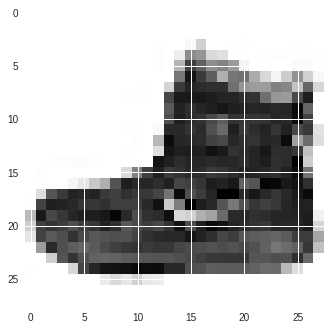

image class: 9


In [8]:
#load datasets
(X_train, y_train_org), (X_test, y_test_org) = fashion_mnist.load_data()

#reshape X
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32")

#normalize X
X_train /= 255.
X_test /= 255.

#explore data
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train_org.shape)
print("y_test shape: ", y_test_org.shape)


#plot sample
plt.imshow(X_train[0,:,:,0])
plt.show()
print("image class:", y_train_org[0])

In [12]:
#how many classes are there?
y_set = set(y_train_org)
print("There are {} classes.".format(len(y_set)))
print(y_set)

There are 10 classes.
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


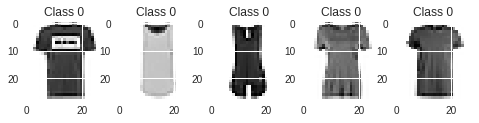

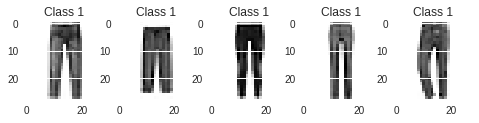

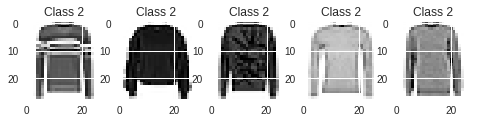

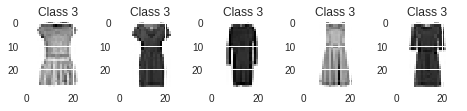

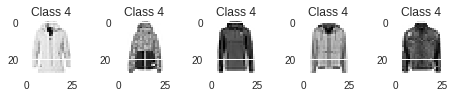

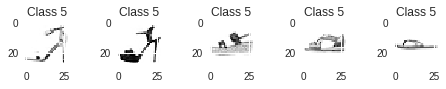

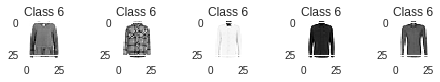

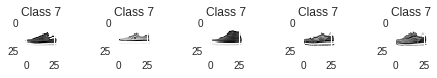

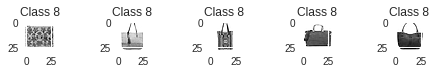

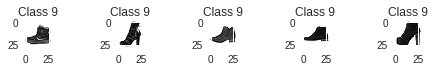

In [26]:
#let's see what each class represents
#fetch sample data for each class
img_classes =list(y_set)

#get first image of each class in the dataset and show image
for c in img_classes:
  for i in range(5):
    plt.subplot(c+1, 5, i+1)
    plt.imshow(X_train[y_train_org == c, :, :, 0][i])
    plt.title("Class "+str(c))
  plt.show()

In [0]:
#generator model
def generator_model():
  model = Sequential()
  model.add(Dense(256, input_shape=(100,))) #input of 100d random noise vector
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Dense(512))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Dense(28*28*1, activation='tanh'))
  model.add(Reshape((28, 28, 1)))
  
  
  noise = Input((100,))
  img = model(noise)
  
  return Model(noise, img)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
dense_106 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 512)               2048      
_________________________________________________________________
dense_107 (Dense)            (None, 1024)              525312    
__________

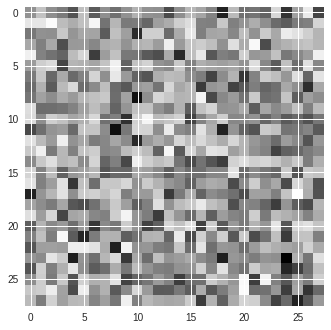

In [86]:
#check how generator is generating random image from the input noise 
noise = np.random.normal(0, 1, (1,100))
gen_img = generator_model().predict(noise)
plt.imshow(gen_img[0,:,:,0])

In [0]:
#discriminator model
def discriminator_model():
  model = Sequential()
  
  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(128, (5, 5), padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(1, activation='sigmoid'))
  
  
  img = Input((28, 28, 1))
  validity = model(img)
  
  return Model(img, validity)

In [0]:
#combined model
def combined_model(generator, discriminator):
  discriminator.trainable = False #do not train the discriminator in the combined model
  
  z = Input((100,))
  img = generator(z)
  validity = discriminator(img)
  
  return Model(z, validity)

In [219]:
#compile discriminator
discriminator = discriminator_model()
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002))

#compile generator model
generator = generator_model()
generator.compile(loss="binary_crossentropy", optimizer='sgd')

#define and compile combined model(GAN)
GAN_model = combined_model(generator, discriminator)
GAN_model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002))
GAN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_33 (Model)             (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_32 (Model)             (None, 1)                 25897217  
Total params: 27,390,737
Trainable params: 1,489,936
Non-trainable params: 25,900,801
_________________________________________________________________


In [220]:
#training phase
EPOCHS = 1500
BATCH_SIZE = 128

#ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))



for epoch in range(EPOCHS):
  #train discriminator
  idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
  imgs = X_train[idx]
  
  noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
  
  gen_imgs = generator.predict(noise)
  
  d_loss_valid = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_valid, d_loss_fake) #compute the average of valid and fake loss
  
  
  #train combined model
  g_loss = GAN_model.train_on_batch(noise, valid)
  
 
  #save sample images every 100 epochs
  #to see how generator is improving in generating images
  gen_images={}
  
  if epoch % 100 == 0:
    print("%d / %d" %(epoch+1, EPOCHS))
    print("[D loss: %f]  [G loss: %f]" %(d_loss, g_loss))
    sample_noise = np.random.normal(0, 1, (10, 100))
    sample_image = generator.predict(sample_noise)
    gen_images[epoch] = sample_image

    


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 / 1500
[D loss: 0.956576]  [G loss: 0.207073]
101 / 1500
[D loss: 0.013961]  [G loss: 9.905468]
201 / 1500
[D loss: 0.024196]  [G loss: 5.812453]
301 / 1500
[D loss: 0.001738]  [G loss: 9.895943]
401 / 1500
[D loss: 0.132503]  [G loss: 5.200534]
501 / 1500
[D loss: 0.047343]  [G loss: 9.219805]
601 / 1500
[D loss: 0.027144]  [G loss: 7.041295]
701 / 1500
[D loss: 0.005768]  [G loss: 8.283070]
801 / 1500
[D loss: 0.022510]  [G loss: 7.419482]
901 / 1500
[D loss: 0.002970]  [G loss: 7.665283]
1001 / 1500
[D loss: 0.009020]  [G loss: 7.199965]
1101 / 1500
[D loss: 0.002760]  [G loss: 7.654771]
1201 / 1500
[D loss: 0.009736]  [G loss: 7.515912]
1301 / 1500
[D loss: 0.001791]  [G loss: 7.632799]
1401 / 1500
[D loss: 0.106995]  [G loss: 7.680792]




*   Discriminatorのlossはかなり低いが、比べてGeneratorのlossは高いままである。
→Discriminatorが強すぎる？



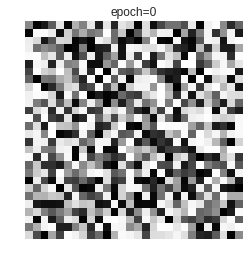

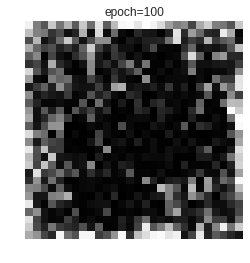

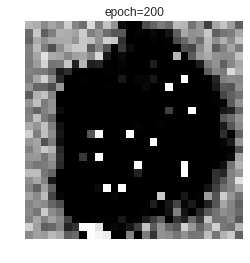

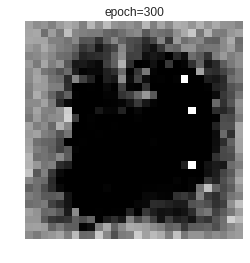

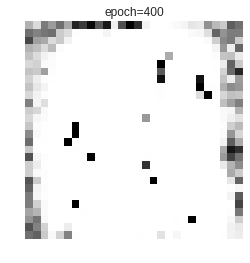

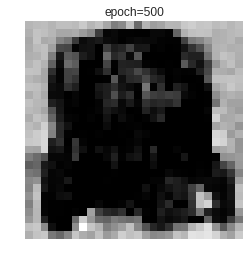

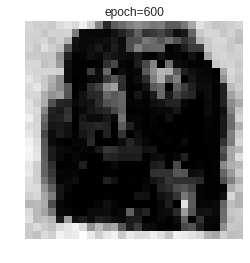

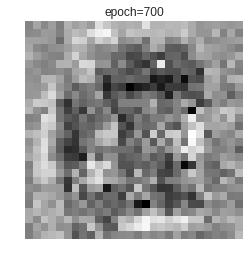

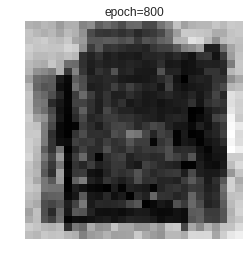

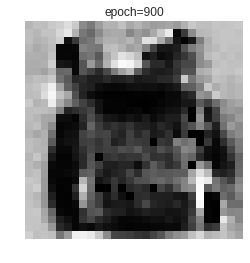

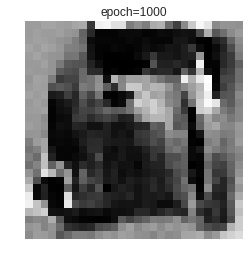

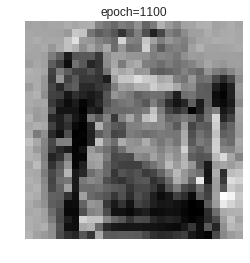

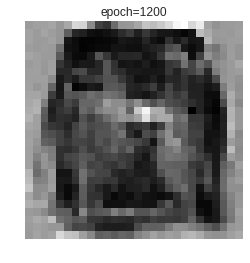

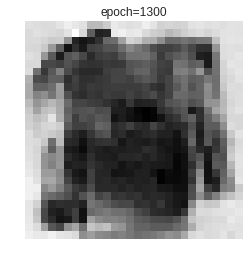

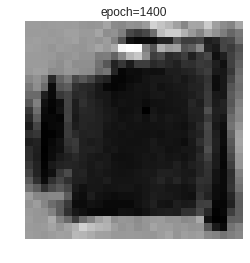

In [217]:
#let's see how generator is improving in generating images
for e, img in gen_images.items():
  plt.imshow(img[0,:,:,0])
  plt.title("epoch=" + str(e))
  plt.axis('off')
  #plt.savefig('Fashin_MNIST_GAN' + str(e) + '.png')  #<= save figures if you like
  plt.show()

epochを重ねるごとに徐々にシャツっぽい形の画像が出力されていっているのがわかる。

が、他のサンプル画像を見るとどれも似たような長袖のシャツの形になっているので、これはいわゆるMode Collapseに陥っている可能性が考えられる。

## Conclusion

**[References]**

[GitHub Keras-GAN by](https://github.com/eriklindernoren/Keras-GAN/blob/master/lsgan/lsgan.py)

[Qiita  DCGANをKerasで実装したった by @yoyoyo様](https://qiita.com/yoyoyo_/items/56c6fcbd5a853460f506)

